# Integrality Gap of Vertex Cover

We will rehash the simple proof that vertex cover problem ILP has an integrality gap of $2$. In other words, the optimal ILP solution is no more than a factor of $2$ away from the optimal LP solution.

Recall the definition of integrality gap. Let us consider a an ILP (minimization problem) $P$ that yields an optimal solution of $p^*$ and a corresponding LP relaxation that yields an optimal solution of $l^*$. 
  - We know that $l^* \leq p^*$ since this is a minimization problem.
  - We have shown examples previously that $l^*$ can be arbitrarily far away from $p^*$.
  
The integrality gap is defined as the ratio between best ILP solution and the best LP relaxation: 
$\frac{p^*}{l^*}$. 

Consider an instance of vertex cover consisting of an undirected graph with vertices $V = \{ 1, \ldots, n\}$ and edges  $\{(i,j)\ |\ i, j \in V \}$. The ILP formulation was presented previously as follows:

  $$
    \begin{array}{rll}
    \min & \sum_{i=1}^n w_i \\ 
    \mathsf{s.t.} & w_i + w_j \geq 1 & \text{for edge}\ (i,j) \in E \\ 
    & w_i \in \{0, 1\} & \text{for}\ i = 1, \ldots, n \\ 
    \end{array}
  $$


Each variable $w_i$ is a binary variable wherein $w_i = 1$ indicates the corresponding vertex $i$ is part of our cover and $w_i= 0$ otherwise.

The LP relaxation is given by 

$$
  \begin{array}{rll}
  \min & \sum_{i=1}^n z_i \\ 
  \mathsf{s.t.} & z_i + z_j \geq 1 & \text{for edge}\ (i,j) \in E \\ 
  & 0 \leq z_i \leq 1 & \text{for}\ i = 1, \ldots, n \\ 
  \end{array}
$$

For convenience, we will use $z_1, \ldots, z_n$ as the decision variables of the LP relaxation in correspondence with $w_1, \ldots, w_n$.

The LP relaxation assumes that $z_i$ can take fractional values between $0$ and $1$ (inclusive). Let $w_1^*, \ldots, w_n^*$ be the optimal ILP solution yielding an optimal vertex cover of size $C^*=\sum_{i=1}^n w_i^*$ while
$z_1^*, \ldots, z_n^*$ be the optimal LP solution yielding objective value $C_f^* =\sum_{i=1}^n z_i^*$.

We know from the properties of LP relaxation that 

$$ C_f^* \leq C^*$$

Now, we will argue the following fact: for each edge $(i,j)$, at least one of $z_i^*$ or $z_j^*$ must be $\geq 0.5$. Why? Note that the edge $(i,j)$ yields the constraint

$$ z_i + z_j \geq 1$$

It is not possible for two fractions $z_i^*, z_j^*$ to sum up to a number greater than or equal to $1$ unless one of them is at least $0.5$.  Let us construct a solution for vertex cover from the LP relaxation as follows:

$$ \widehat{z_i} = \begin{cases} 1 & \text{if}\ z_i^* \geq 0.5 \\ 
0 & \text{otherwise} \\ 
\end{cases}$$

In other words, $\widehat{z_i}$ is just rounding $z_i^*$ up to 1 or down to 0.

### Claim 1: The solution $\widehat{z_1}, \ldots, \widehat{z_n}$ is a feasible solution to the ILP.

To see this, consider any edge $(i, j)$. We know that at least one of $z_i^*, z_j^*$ must be greater than or equal to $0.5$. Therefore, at least one of $\widehat{z_i}, \widehat{z_j}$ must be rounded up to $1$.  Therefore, $\widehat{z_i} + \widehat{z_j} \geq 1$ for each $(i,j)$. 

In other words, if we chose a vertex cover based on  $\widehat{z_1}, \ldots, \widehat{z_n}$ it would be a valid (though not necessarily optimal) vertex cover. 

Since $\widehat{z_i} \leq 2 z_i^*$ (check both cases of rounding satisfy this),  we note that $\sum_{i=1}^n \widehat{z_i} \leq 2 \sum_{i=1}^n z_i^*$.

Combining, we get the following set of inequalities.

$$ \sum_{i=1}^n z_i^* \underset{\fbox{ A}}{\leq} \sum_{j=1}^n w_j^* \underset{\fbox{ B}}{\leq} \sum_{i=1}^n \widehat{z_i} \leq 2 \sum_{j=1}^n z_i^* $$

 - A: LP relaxation vs ILP solution.
 - B: optimal ILP solution objective is less than equal to any feasible ILP solution.
 
This proves, that $\frac{\sum_{j=1}^n w_j^*}{\sum_{j=1}^n z_i^*} \leq 2$ assuming that the graph has at least one edge (otherwise the denominator can be $0$).

### Approximation

This also provides a scheme to approximate the solution to a ILP. For instance, we can take the LP relaxation and simply round it up/down as specified above. This gives a fast solution to vertex cover that is no more than factor of 2 off from the best possible solution. We will study these approximation algorithms next lesson.

In [8]:
from pulp import *


def compute_optimal_vertex_cover(n, edge_list):
    # Create a problem -- indicate that we will minimize the objectives
    prob = LpProblem('vert_cover', LpMinimize)
    # Add all the decision vars (we do this using comprehensions in Python but you could write a for-loop as well)
    dvars = [LpVariable(f'w_{i}', cat='Binary') for i in range(1, n+1)]
    # Note that lpSum is defined in Pulp and it simply takes the sum of all variables in a list of vars.
    prob += lpSum(dvars) # minimize the sum of the variables
    for (i, j) in edge_list: # go through each edge in the list
        assert 1 <= i <= n 
        assert 1 <= j <= n
        prob += dvars[i-1] + dvars[j-1] >= 1 # add the constraint -- wi + wj >= 1 -- indexing in python starts from 0 and thus we require the -1
    stat = prob.solve(PULP_CBC_CMD(msg=False)) # solve the problem but suppress output
    assert stat == LpStatusOptimal, 'Problem does not have optimal status -- something went wrong -- this should not happen for this problem'
    vert_cover = [i+1 for i in range(n) if dvars[i].varValue > 0 ]
    return len(vert_cover)

In [15]:
def compute_lp_relaxation_vertex_cover(n, edge_list):
    # Create a problem -- indicate that we will minimize the objectives
    prob = LpProblem('vert_cover', LpMinimize)
    # Add all the decision vars (we do this using comprehensions in Python but you could write a for-loop as well)
    dvars = [LpVariable(f'z_{i}', lowBound=0.0, upBound=1.0, cat='Continuous') for i in range(1, n+1)]
    # Note that lpSum is defined in Pulp and it simply takes the sum of all variables in a list of vars.
    prob += lpSum(dvars) # minimize the sum of the variables
    for (i, j) in edge_list: # go through each edge in the list
        assert 1 <= i <= n 
        assert 1 <= j <= n
        prob += dvars[i-1] + dvars[j-1] >= 1 # add the constraint -- wi + wj >= 1 -- indexing in python starts from 0 and thus we require the -1
    stat = prob.solve(PULP_CBC_CMD(msg=False)) # solve the problem but suppress the output
    assert stat == LpStatusOptimal, 'Problem does not have optimal status -- something went wrong -- this should not happen for this problem'
    vert_cover = [x.varValue for x in dvars]
    return sum(vert_cover)

# n = 7
# edge_list = [(1, 2), (1, 3), (1, 4), (2, 3), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (4, 7), (5, 6), (5, 7) ,(6, 7)]
# compute_optimal_vertex_cover(n, edge_list)
# compute_lp_relaxation_vertex_cover(n, edge_list)


5

In [3]:
## generate a random graph with n nodes and m edges + compute both optimal cover using ILP and LP relaxations
from random import randint
def formulate_random_problem(n, m):
    # n vertices and m edges
    edge_list = []
    for i in range(m):
        done = False
        vi= 1
        vj = n
        while not done: # get two random vertices
            vi, vj = randint(1, n), randint(1, n)
            vi, vj = min(vi, vj), max(vi, vj)
            if vi != vj and (vi, vj) not in edge_list: # if they are not the same vertex or we have not seen the edge previously
                done = True
        edge_list.append((vi, vj))
    assert len(edge_list) == m
    n1 = compute_optimal_vertex_cover(n, edge_list)
    n2 = compute_lp_relaxation_vertex_cover(n, edge_list)
    return (n1, n2)


In [4]:
# run 50 different random problems
# Each problem generates a random graph with 50 vertices and 240 edges
# This is going to take quite some time
opt_vertex_cover = []
lp_relax_obj = []
print('Opt Cover, Lp Relaxation')
print('------------------------')
for i in range(250):
    n = randint(15, 60)
    m = randint(n*2, n*5)
    print(f'n = {n}, m={m}')
    (n1, n2) = formulate_random_problem(n, m) 
    opt_vertex_cover.append(n1)
    lp_relax_obj.append(n2)
    print(f'opt-cover={n1}, lp-relax={n2}')

Opt Cover, Lp Relaxation
------------------------
n = 17, m=43
opt-cover=11, lp-relax=8.5
n = 40, m=90
opt-cover=23, lp-relax=20.0
n = 51, m=103
opt-cover=27, lp-relax=25.0
n = 55, m=130
opt-cover=31, lp-relax=27.0
n = 18, m=47
opt-cover=11, lp-relax=9.0
n = 53, m=200
opt-cover=34, lp-relax=26.5
n = 15, m=75
opt-cover=12, lp-relax=7.5
n = 17, m=70
opt-cover=12, lp-relax=8.5
n = 59, m=243
opt-cover=39, lp-relax=29.5
n = 28, m=134
opt-cover=20, lp-relax=14.0
n = 22, m=52
opt-cover=12, lp-relax=11.0
n = 46, m=222
opt-cover=32, lp-relax=23.0
n = 53, m=108
opt-cover=29, lp-relax=26.5
n = 57, m=161
opt-cover=35, lp-relax=28.5
n = 60, m=153
opt-cover=36, lp-relax=30.0
n = 48, m=240
opt-cover=34, lp-relax=24.0
n = 47, m=196
opt-cover=32, lp-relax=23.5
n = 16, m=35
opt-cover=9, lp-relax=8.0
n = 39, m=160
opt-cover=27, lp-relax=19.5
n = 54, m=242
opt-cover=37, lp-relax=27.0
n = 35, m=153
opt-cover=24, lp-relax=17.5
n = 55, m=157
opt-cover=33, lp-relax=27.5
n = 36, m=172
opt-cover=25, lp-relax=18

Text(0, 0.5, 'Optimal Cover')

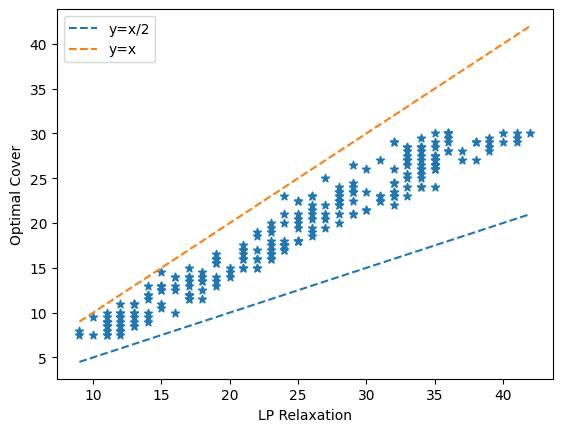

In [5]:
from matplotlib import pyplot as plt
import numpy as np
plt.scatter(opt_vertex_cover, lp_relax_obj,marker='*')
x = np.linspace(min(opt_vertex_cover), max(opt_vertex_cover), 50)
y = x/2
plt.plot(x,y, '--', label='y=x/2')
plt.plot(x,x, '--', label='y=x')
plt.legend()
plt.xlabel('LP Relaxation')
plt.ylabel('Optimal Cover')


Note from the scatter plot above the integrality gap is quite clearly illustrated though the experiments do not constitute a proof. Nevertheless, it is interesting to look at this kind of empirical data sometimes.

## That's all folks!